In [8]:
import pandas as pd

# Load data
df = pd.read_excel("dataset_roughness.xlsx")

# Select columns
columns = ['f', 'ap', 'ae', 'Rz']
df = df[columns]

print(df.head())
print(f'Data set size: {len(df)} datapoints.')



      f        ap        ae     Rz
0  2160  0.306716  7.066666  0.704
1  2160  0.306716  7.066666  0.679
2  2160  0.306716  7.066666  0.651
3  2160  0.306893  7.116666  0.704
4  2160  0.306893  7.116666  0.670
Data set size: 280 datapoints.


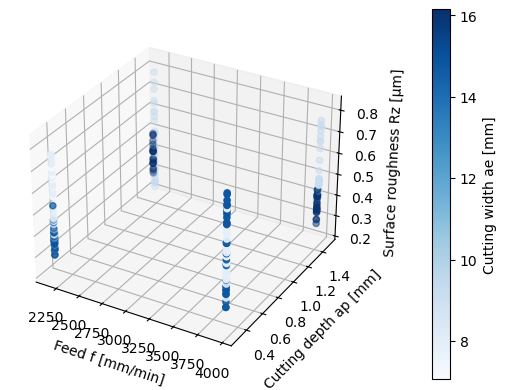

In [9]:
import matplotlib.pyplot as plt
# visualize data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
graph = ax.scatter(df.f, df.ap, df.Rz, c=df.ae, cmap='Blues')
cbar = fig.colorbar(graph, ax=ax, pad=0.15)    #Beschriftung z-Achse wird von Farbskala bedeckt: cbar = fig.colorbar(graph, ax=ax, pad=0.15)
ax.set_xlabel('Feed f [mm/min]')
ax.set_ylabel('Cutting depth ap [mm]')
ax.set_zlabel('Surface roughness Rz [µm]')
cbar.set_label('Cutting width ae [mm]')


plt.show()

Aggregated dataset size: 76 datapoints


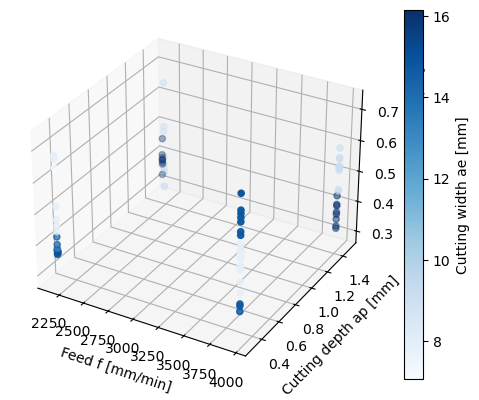

In [14]:
# Aggregate data
df_agg = df.groupby(['f', 'ap', 'ae'])['Rz'].aggregate('mean').reset_index()

print(f'Aggregated dataset size: {len(df_agg)} datapoints')

# Visualize aggregated data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
graph = ax.scatter(df_agg.f, df_agg.ap, df_agg.Rz, c=df_agg.ae, cmap='Blues')

cbar = fig.colorbar(graph, ax=ax)
ax.set_xlabel('Feed f [mm/min]')
ax.set_ylabel('Cutting depth ap [mm]')
ax.set_zlabel('Surface roughness Rz [µm]')
cbar.set_label('Cutting width ae [mm]')

plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler

# Split data
training_data_ratio = 0.7
data_train = df_agg.sample(frac=training_data_ratio, random_state=0)
data_test = df_agg.drop(data_train.index)

train_input, train_label = data_train.drop('Rz', axis=1), data_train.Rz
test_input, test_label = data_test.drop('Rz', axis=1), data_test.Rz

print("Train set size:", train_input.shape)
print("Test set size:", test_input.shape)

# Scale the input features 
scaler = StandardScaler()
scaler.fit(train_input)
train_input = scaler.transform(train_input)
test_input = scaler.transform(test_input)



Train set size: (53, 3)
Test set size: (23, 3)


In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Set up regressor
neuralnet = MLPRegressor(activation='relu', solver='adam', max_iter=5000)

# Define hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(10,10), (25,25), (50,50), (100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Grid search
gridsearch_cv = GridSearchCV(estimator=neuralnet, param_grid=param_grid, cv=5,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_cv.fit(train_input, train_label)


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=5000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10, 10), (25, 25), (50, 50),
                                                (100, 100)],
                         'learning_rate_init': [0.001, 0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Best model from grid search
best_model = gridsearch_cv.best_estimator_

# Predict test set
test_prediction = best_model.predict(test_input)

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(test_label, test_prediction))
print(f'Test set RMSE: {test_rmse}') 

# Print best hyperparameters
print(f'Best grid search RMSE: {-gridsearch_cv.best_score_}')
print(f'Best params: {gridsearch_cv.best_params_}')


Test set RMSE: 0.10322545135039438
Best grid search RMSE: 0.07857637994401054
Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.01}
